In [1]:
import numpy as np
import pandas as pd
from keras import datasets
from keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Flatten, Reshape, BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
import mplfinance as mpf

/Users/ryousukekaga/repositories/forex-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = pd.read_table("./data/EURUSD_D1.csv", names=["datetime", "open", "high", "low", "close", "volume"])
data.drop("volume", inplace=True, axis=1)

<Axes: >

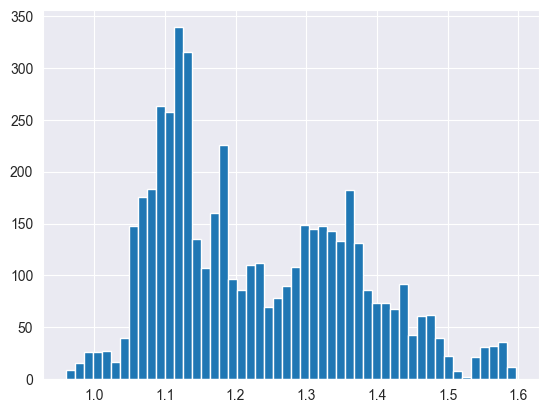

In [3]:
data["open"].hist(bins=50)

In [4]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    verbose_feature_names_out=False
)

data = pd.DataFrame(preprocessing.fit_transform(data), columns=preprocessing.get_feature_names_out())

num_data = data.select_dtypes(include="number")

<Axes: >

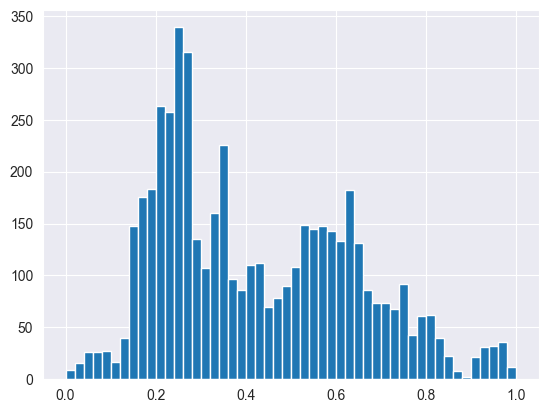

In [5]:
data["open"].hist(bins=50)

In [6]:
WINDOW = 24

windows = np.array(list(num_data.rolling(window=WINDOW))[WINDOW:])

In [7]:
EMBEDDING_DIM = 2

In [8]:
encoder_input = Input(shape=(WINDOW, 4))
x = Conv1D(32, 3, strides=2, activation='relu', padding="same")(encoder_input)
x = Conv1D(64, 3, strides=2, activation='relu', padding="same")(x)
x = Conv1D(128, 3, strides=2, activation='relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
x = BatchNormalization()(x)
encoder_output = Dense(EMBEDDING_DIM, name="encoder_output")(x)
encoder = Model(encoder_input, encoder_output)

In [9]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 4)]           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 32)            416       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 128)            24704     
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 batch_normalization (Batch  (None, 384)               1536      
 Normalization)                                                  
                                                             

In [10]:
shape_before_flattening

(3, 128)

In [11]:
decoder_input = Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = BatchNormalization()(x)
x = Conv1DTranspose(128, 3, strides=2, activation='relu', padding="same")(x)
x = Conv1DTranspose(64, 3, strides=2, activation='relu', padding="same")(x)
x = Conv1DTranspose(32, 3, strides=2, activation='relu', padding="same")(x)
decoder_output = Conv1D(4, 3, strides=1, activation="relu", padding="same")(x)
decoder = Model(decoder_input, decoder_output)

In [12]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 384)               1152      
                                                                 
 reshape (Reshape)           (None, 3, 128)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 3, 128)            512       
 chNormalization)                                                
                                                                 
 conv1d_transpose (Conv1DTr  (None, 6, 128)            49280     
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 12, 64)            2464

In [13]:
autoencoder = Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 4)]           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 32)            416       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 128)            24704     
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 batch_normalization (Batch  (None, 384)               1536      
 Normalization)                                                  
                                                           

In [14]:
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss="binary_crossentropy")

In [15]:
autoencoder.fit(windows, windows, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
156/156 [==============================] - 1s 4ms/step - loss: 0.7342
Epoch 2/50
156/156 [==============================] - 1s 4ms/step - loss: 0.6249
Epoch 3/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5948
Epoch 4/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5977
Epoch 5/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5946
Epoch 6/50
156/156 [==============================] - 1s 5ms/step - loss: 0.5942
Epoch 7/50
156/156 [==============================] - 1s 5ms/step - loss: 0.5920
Epoch 8/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5899
Epoch 9/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5881
Epoch 10/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5895
Epoch 11/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5890
Epoch 12/50
156/156 [==============================] - 1s 4ms/step - loss: 0.5966
Epoch 13/50
156/156 [====

In [16]:
predictions = autoencoder.predict(windows)

156/156 [==============================] - 0s 1ms/step


In [17]:
embeddings = encoder.predict(windows)

156/156 [==============================] - 0s 527us/step


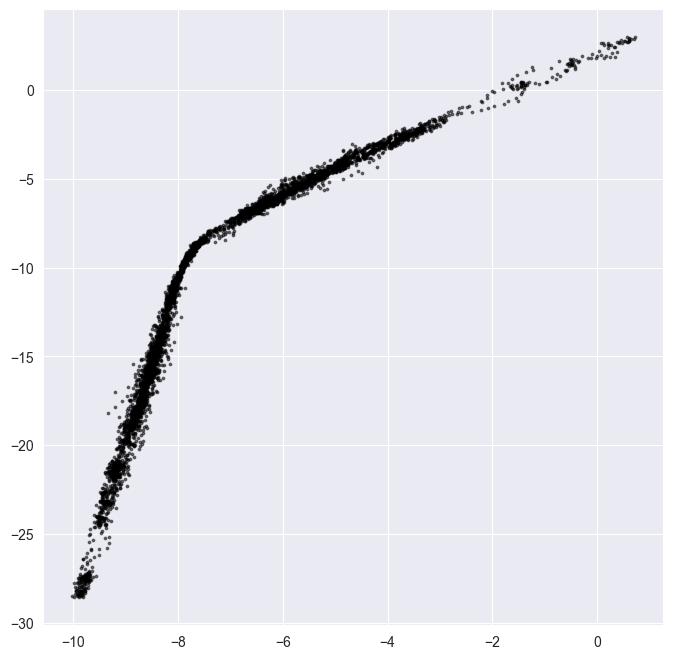

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)

In [32]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(20, 2))
reconstruction = decoder.predict(sample)[0] 

1/1 [==============================] - 0s 13ms/step


In [33]:
reconstruction.shape[0]

24

In [34]:
reconstruction = pd.DataFrame(preprocessing.named_transformers_["pipeline"]["minmaxscaler"].inverse_transform(reconstruction), columns=['Open', 'Low', 'High', 'Close'])
reconstruction.index = pd.date_range('1/1/2021',periods=(reconstruction.shape[0]))

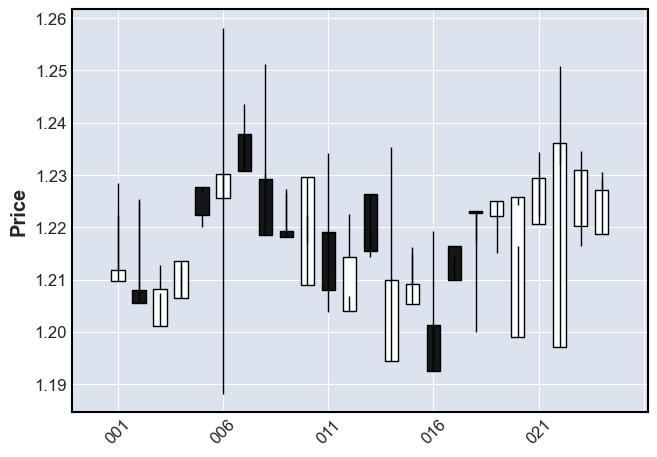

In [35]:
mpf.plot(reconstruction, type='candle', datetime_format='%j')